In [87]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/data/upgrad/SEM3/Churn_Casestudy/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/data/upgrad/SEM3/Churn_Casestudy


In [88]:
import pandas as pd
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek

In [89]:
# Defining functions

# Function for outlier capping

def cap_outliers(df):
  df = df.copy()
  Q1 = df3.quantile(0.25)
  Q3 = df3.quantile(0.75)
  IQR = Q3 - Q1
  outliers = ((df < (Q1 - 1.5 * IQR))|(df > (Q3 + 1.5 * IQR))).any(axis=0)
  outliers_cols = list(outliers[outliers].index)
  df[outliers_cols] = df[outliers_cols].clip(df[outliers_cols].quantile(0.01) , df[outliers_cols].quantile(0.99), axis = 1)
  return df


# Function for plotting histogram and boxplot

def plot_numerical(data,numerical_var,target_var):
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
  fig.tight_layout(pad=5.0)

  sns.distplot(data[numerical_var], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3}, ax=axes[0])
  
  data[numerical_var].dropna().plot(kind = "box", ax = axes[1]) #, figsize = (20,10)

  sns.boxplot(x=target_var, y=numerical_var, data=data, ax=axes[2],showfliers = False)


# Function for printing different scores
def print_scores(model, X_test, y_test, mode='Test'):
  from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

  print(f"\n {mode} Set ROC AUC: ".format(mode), round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),2))
  print(f'\n Clasification Report on {mode} Set:\n'.format(mode), classification_report(y_test,model.predict(X_test)))
  print(f'\n Confussion Matrix:\n',confusion_matrix(y_test, model.predict(X_test)))

In [90]:
df = pd.read_csv("telecom_churn_data.csv",parse_dates=True)
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [92]:
df.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621

In [93]:
# List of columns in df
df_cols = list(df.columns)

# Checking cardinality of categorical vars

for i in df_cols:
    unique_categories = df[i].value_counts().shape[0]
    print('{} has {} unique values'.format(i, unique_categories))

mobile_number has 99999 unique values
circle_id has 1 unique values
loc_og_t2o_mou has 1 unique values
std_og_t2o_mou has 1 unique values
loc_ic_t2o_mou has 1 unique values
last_date_of_month_6 has 1 unique values
last_date_of_month_7 has 1 unique values
last_date_of_month_8 has 1 unique values
last_date_of_month_9 has 1 unique values
arpu_6 has 85681 unique values
arpu_7 has 85308 unique values
arpu_8 has 83615 unique values
arpu_9 has 79937 unique values
onnet_mou_6 has 24313 unique values
onnet_mou_7 has 24336 unique values
onnet_mou_8 has 24089 unique values
onnet_mou_9 has 23565 unique values
offnet_mou_6 has 31140 unique values
offnet_mou_7 has 31023 unique values
offnet_mou_8 has 30908 unique values
offnet_mou_9 has 30077 unique values
roam_ic_mou_6 has 6512 unique values
roam_ic_mou_7 has 5230 unique values
roam_ic_mou_8 has 5315 unique values
roam_ic_mou_9 has 4827 unique values
roam_og_mou_6 has 8038 unique values
roam_og_mou_7 has 6639 unique values
roam_og_mou_8 has 6504 un

In [94]:
one_unique_value_cols = ['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 
                         'last_date_of_month_9', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9','std_ic_t2o_mou_6', 
                         'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9','circle_id' ]

# Dropping columns with one unique value (zero variance)
df = df.drop(one_unique_value_cols, axis = 1)

In [95]:
# Checking for null percentage in each column

df.isnull().mean().sort_values(ascending = False)*100

night_pck_user_6            74.846748
arpu_2g_6                   74.846748
count_rech_3g_6             74.846748
av_rech_amt_data_6          74.846748
count_rech_2g_6             74.846748
max_rech_data_6             74.846748
fb_user_6                   74.846748
date_of_last_rech_data_6    74.846748
total_rech_data_6           74.846748
arpu_3g_6                   74.846748
night_pck_user_7            74.428744
arpu_2g_7                   74.428744
total_rech_data_7           74.428744
arpu_3g_7                   74.428744
max_rech_data_7             74.428744
av_rech_amt_data_7          74.428744
count_rech_3g_7             74.428744
date_of_last_rech_data_7    74.428744
count_rech_2g_7             74.428744
fb_user_7                   74.428744
date_of_last_rech_data_9    74.077741
arpu_2g_9                   74.077741
max_rech_data_9             74.077741
count_rech_3g_9             74.077741
fb_user_9                   74.077741
av_rech_amt_data_9          74.077741
total_rech_d

In [96]:
# Replacing nulls in columns mentioned in "data_rech_(6/7/8/9)" list with 0 when all these columns & date_of_last_rech_data are nulls
# In other words, no data recharge was done by the customer, hence replacing nulls with 0 

# data_rech_6
data_rech_6 = ['max_rech_data_6','av_rech_amt_data_6','total_rech_data_6','count_rech_2g_6','count_rech_3g_6','arpu_2g_6', 'arpu_3g_6']

df.loc[df.date_of_last_rech_data_6.isnull() & df.max_rech_data_6.isnull() & df.av_rech_amt_data_6.isnull() & df.total_rech_data_6.isnull() 
& df.count_rech_2g_6.isnull() & df.count_rech_3g_6.isnull() & df.arpu_2g_6.isnull() & df.arpu_3g_6.isnull(), data_rech_6] = df[data_rech_6].fillna(0)


# data_rech_7
data_rech_7 = ['max_rech_data_7','av_rech_amt_data_7','total_rech_data_7','count_rech_2g_7','count_rech_3g_7','arpu_2g_7', 'arpu_3g_7']

df.loc[df.date_of_last_rech_data_7.isnull() & df.max_rech_data_7.isnull() & df.av_rech_amt_data_7.isnull() & df.total_rech_data_7.isnull() 
& df.count_rech_2g_7.isnull() & df.count_rech_3g_7.isnull() & df.arpu_2g_7.isnull() & df.arpu_3g_7.isnull(), data_rech_7] = df[data_rech_7].fillna(0)


# data_rech_8
data_rech_8 = ['max_rech_data_8','av_rech_amt_data_8','total_rech_data_8','count_rech_2g_8','count_rech_3g_8','arpu_2g_8', 'arpu_3g_8']

df.loc[df.date_of_last_rech_data_8.isnull() & df.max_rech_data_8.isnull() & df.av_rech_amt_data_8.isnull() & df.total_rech_data_8.isnull() 
& df.count_rech_2g_8.isnull() & df.count_rech_3g_8.isnull() & df.arpu_2g_8.isnull() & df.arpu_3g_8.isnull(), data_rech_8] = df[data_rech_8].fillna(0)


# data_rech_9
data_rech_9 = ['max_rech_data_9','av_rech_amt_data_9','total_rech_data_9','count_rech_2g_9','count_rech_3g_9','arpu_2g_9', 'arpu_3g_9']

df.loc[df.date_of_last_rech_data_9.isnull() & df.max_rech_data_9.isnull() & df.av_rech_amt_data_9.isnull() & df.total_rech_data_9.isnull() 
& df.count_rech_2g_9.isnull() & df.count_rech_3g_9.isnull() & df.arpu_2g_9.isnull() & df.arpu_3g_9.isnull(), data_rech_9] = df[data_rech_9].fillna(0)


Creating dummy variables

In [97]:
# Converting night_pck_user and fb_user columns to object format
nightpck_fb_user = ["night_pck_user_6","night_pck_user_7","night_pck_user_8","night_pck_user_9","fb_user_6", "fb_user_7","fb_user_8","fb_user_9"]
df[nightpck_fb_user] = df[nightpck_fb_user].astype(str)

# Replacing 1 with "Y" (Yes), 0 with "N" (No) and nulls with "M" (Missings) in "night_pck_user" variables and "fb_user" variables
for i in nightpck_fb_user:
  df[i] = df[i].map({"1.0":"Y", "0.0":"N", "nan": "M"})

# Creating dummy variables 
df_dummies = pd.get_dummies(df[nightpck_fb_user], drop_first = True)
df = pd.concat([df, df_dummies], axis = 1)

# Dropping all columns in nightpck_fb_user as we have made their dummies
df = df.drop(nightpck_fb_user, axis = 1)

In [98]:
# Checking for null percentage in each column

df.isnull().mean().sort_values(ascending = False)*100

date_of_last_rech_data_6    74.846748
date_of_last_rech_data_7    74.428744
date_of_last_rech_data_9    74.077741
date_of_last_rech_data_8    73.660737
ic_others_9                  7.745077
std_og_t2t_mou_9             7.745077
loc_og_t2m_mou_9             7.745077
isd_ic_mou_9                 7.745077
loc_og_t2f_mou_9             7.745077
loc_og_t2c_mou_9             7.745077
loc_og_mou_9                 7.745077
loc_ic_t2f_mou_9             7.745077
std_og_t2m_mou_9             7.745077
loc_ic_t2m_mou_9             7.745077
spl_ic_mou_9                 7.745077
std_og_t2f_mou_9             7.745077
loc_ic_t2t_mou_9             7.745077
std_og_mou_9                 7.745077
isd_og_mou_9                 7.745077
std_ic_t2t_mou_9             7.745077
spl_og_mou_9                 7.745077
loc_og_t2t_mou_9             7.745077
og_others_9                  7.745077
loc_ic_mou_9                 7.745077
onnet_mou_9                  7.745077
std_ic_mou_9                 7.745077
roam_ic_mou_

In [99]:
# Dropping date columns with high (~74%) missings

df = df.drop(['date_of_last_rech_data_6','date_of_last_rech_data_7', 'date_of_last_rech_data_9', 'date_of_last_rech_data_8'],axis = 1)

In [100]:
# Checking what categorcial variables look like

df.select_dtypes(include = "O").head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9
0,6/21/2014,7/16/2014,8/8/2014,9/28/2014
1,6/29/2014,7/31/2014,8/28/2014,9/30/2014
2,6/17/2014,7/24/2014,8/14/2014,9/29/2014
3,6/28/2014,7/31/2014,8/31/2014,9/30/2014
4,6/26/2014,7/28/2014,8/9/2014,9/28/2014


In [101]:
# Changing all dates to date time format

datecols = ["date_of_last_rech_6", "date_of_last_rech_7", "date_of_last_rech_8","date_of_last_rech_9"]
df[datecols] = df[datecols].apply(pd.to_datetime, errors = 'coerce')

## Filtering high-value customers

In [102]:
# Grouping by mobile numbers to find total recharge by each mobile number for the months 6 and 7

rchrg_1st_2mnths = df.groupby(['mobile_number'])[['total_rech_amt_6', 'total_rech_amt_7']].sum()
rchrg_1st_2mnths.head() 

,total_rech_amt_6,total_rech_amt_7
mobile_number,,
7000000074,2290,1876
7000000090,300,200
7000000126,196,200
7000000149,556,30
7000000204,314,0


In [103]:
# Average recharge done by each number 
rchrg_1st_2mnths["avg_recharge_month_6/7"]  = rchrg_1st_2mnths.mean(axis = 1)

# Dropping 'total_rech_num_6' and 'total_rech_num_7'
rchrg_1st_2mnths = rchrg_1st_2mnths.drop(['total_rech_amt_6','total_rech_amt_7'],axis = 1)

rchrg_1st_2mnths.head()

,avg_recharge_month_6/7
mobile_number,
7000000074,2083.0
7000000090,250.0
7000000126,198.0
7000000149,293.0
7000000204,157.0


In [104]:
# 70th percentile of avg_recharge_month_6/7
percentile_70 = rchrg_1st_2mnths['avg_recharge_month_6/7'].quantile(0.70)

# Assigning high-value customers as 1
rchrg_1st_2mnths.loc[rchrg_1st_2mnths['avg_recharge_month_6/7'] >= percentile_70 ,"high_value_cust"] = 1
rchrg_1st_2mnths.loc[rchrg_1st_2mnths['avg_recharge_month_6/7'] < percentile_70 ,"high_value_cust"] = 0

In [105]:
# Filtering high-value customers in a new data frame called df1

df1 = pd.Series(rchrg_1st_2mnths[rchrg_1st_2mnths['high_value_cust']==1.0].index)
df1.head()

0    7000000074
1    7000000229
2    7000000256
3    7000000267
4    7000000314
Name: mobile_number, dtype: int64

In [106]:
# Joining df and df1 using inner join so that df2 contains only high-value customers

df2 = df.merge(df1,on = "mobile_number" , how = "inner")
df2 = df2.set_index("mobile_number")
df2.head()

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,night_pck_user_6_N,night_pck_user_6_Y,night_pck_user_7_N,night_pck_user_7_Y,night_pck_user_8_N,night_pck_user_8_Y,night_pck_user_9_N,night_pck_user_9_Y,fb_user_6_N,fb_user_6_Y,fb_user_7_N,fb_user_7_Y,fb_user_8_N,fb_user_8_Y,fb_user_9_N,fb_user_9_Y
mobile_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7000701601,1069.180,1349.850,3171.480,500.000,57.84,54.68,52.29,NaN,453.43,567.16,325.91,NaN,16.23,33.49,31.64,NaN,23.74,12.59,38.06,NaN,51.39,31.38,40.28,NaN,308.63,447.38,162.28,NaN,62.13,55.14,53.23,NaN,0.0,0.0,0.00,NaN,422.16,533.91,255.79,NaN,4.30,23.29,12.01,NaN,49.89,31.76,49.14,NaN,6.66,20.08,16.68,NaN,60.86,75.14,77.84,NaN,0.0,0.18,10.01,NaN,4.50,0.00,6.50,NaN,0.00,0.0,0.0,NaN,487.53,609.24,350.16,0.00,58.14,32.26,27.31,NaN,217.56,221.49,121.19,NaN,152.16,101.46,39.53,NaN,427.88,355.23,188.04,NaN,36.89,11.83,30.39,NaN,91.44,126.99,141.33,NaN,52.19,34.24,22.21,NaN,180.54,173.08,193.94,NaN,626.46,558.04,428.74,0.00,0.21,0.0,0.0,NaN,2.06,

## Deriving Churn

In [107]:
# Creating a new column churn which has a value of 1 for churn and 0 for no churn

df2.loc[(df2['total_og_mou_9'] == 0) & (df2['total_og_mou_9'] == 0) & (df2['vol_2g_mb_9'] == 0) & (df2['vol_3g_mb_9'] == 0)  ,"churn"] = 1
df2['churn'] = df2['churn'].fillna(0)

len(df2)

30011

After filtering the high-value customers we are left with 30011 rows

## Dropping all variables related to month "9"

In [108]:
# Dropping columns relating to the last month (9)

cols_9 = [i for i in df2.columns if '_9' in i[:]]
df2 = df2.drop(cols_9 ,axis = 1)


## Data Preparation

In [109]:
# Checking for null percentage in each column

df2.isnull().mean().sort_values(ascending = False)*100

isd_og_mou_8           3.125521
spl_og_mou_8           3.125521
loc_ic_t2t_mou_8       3.125521
og_others_8            3.125521
loc_og_t2c_mou_8       3.125521
loc_ic_t2m_mou_8       3.125521
loc_og_t2f_mou_8       3.125521
std_og_t2t_mou_8       3.125521
loc_ic_t2f_mou_8       3.125521
loc_og_t2m_mou_8       3.125521
std_og_mou_8           3.125521
loc_ic_mou_8           3.125521
loc_og_t2t_mou_8       3.125521
ic_others_8            3.125521
roam_og_mou_8          3.125521
isd_ic_mou_8           3.125521
roam_ic_mou_8          3.125521
std_og_t2m_mou_8       3.125521
spl_ic_mou_8           3.125521
offnet_mou_8           3.125521
std_ic_t2t_mou_8       3.125521
onnet_mou_8            3.125521
std_ic_t2m_mou_8       3.125521
std_ic_mou_8           3.125521
std_og_t2f_mou_8       3.125521
std_ic_t2f_mou_8       3.125521
loc_og_mou_8           3.125521
date_of_last_rech_8    1.979274
loc_ic_t2t_mou_6       1.052947
og_others_6            1.052947
spl_og_mou_6           1.052947
loc_ic_m

In [110]:
# Replacing nulls in date columns with their median values
datecols = ["date_of_last_rech_6", "date_of_last_rech_7", "date_of_last_rech_8"]

for i in datecols:
  df2[i] = df2[i].fillna(df2[i].quantile(0.5))
  

# Replacing nulls in each column with it's resepctive median value
df2 = df2.fillna(df2.median())

# Checking for null percentage in each column
df2.isnull().mean().sort_values(ascending = False)*100

churn                  0.0
std_og_mou_7           0.0
loc_ic_t2m_mou_7       0.0
loc_ic_t2m_mou_6       0.0
loc_ic_t2t_mou_8       0.0
loc_ic_t2t_mou_7       0.0
loc_ic_t2t_mou_6       0.0
total_og_mou_8         0.0
total_og_mou_7         0.0
total_og_mou_6         0.0
og_others_8            0.0
og_others_7            0.0
og_others_6            0.0
spl_og_mou_8           0.0
spl_og_mou_7           0.0
spl_og_mou_6           0.0
isd_og_mou_8           0.0
isd_og_mou_7           0.0
isd_og_mou_6           0.0
loc_ic_t2m_mou_8       0.0
loc_ic_t2f_mou_6       0.0
loc_ic_t2f_mou_7       0.0
std_ic_t2m_mou_8       0.0
total_ic_mou_6         0.0
std_ic_mou_8           0.0
std_ic_mou_7           0.0
std_ic_mou_6           0.0
std_ic_t2f_mou_8       0.0
std_ic_t2f_mou_7       0.0
std_ic_t2f_mou_6       0.0
std_ic_t2m_mou_7       0.0
loc_ic_t2f_mou_8       0.0
std_ic_t2m_mou_6       0.0
std_ic_t2t_mou_8       0.0
std_ic_t2t_mou_7       0.0
std_ic_t2t_mou_6       0.0
loc_ic_mou_8           0.0
l

Now we can observe that there are no null values in the dataset.

In [111]:
df2.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,night_pck_user_6_N,night_pck_user_6_Y,night_pck_user_7_N,night_pck_user_7_Y,night_pck_user_8_N,night_pck_user_8_Y,fb_user_6_N,fb_user_6_Y,fb_user_7_N,fb_user_7_Y,fb_user_8_N,fb_user_8_Y,churn
count,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.00000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.

In [112]:
df2.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,night_pck_user_6_N,night_pck_user_6_Y,night_pck_user_7_N,night_pck_user_7_Y,night_pck_user_8_N,night_pck_user_8_Y,fb_user_6_N,fb_user_6_Y,fb_user_7_N,fb_user_7_Y,fb_user_8_N,fb_user_8_Y,churn
mobile_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,2014-06-27,2014-07-25,2014-08-26,0,0,779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,130.26,143.48,98.28,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,2014-06-25,2014-07-31,2014-08-30,50,0,10,0.0,2.0,3.0,0.0,154.0,23.0,0.0,2.0,3.0,0.0,0.0

Remove Highly Correlated Variables

In [113]:
# Checking highly correlated variables

corr = abs(df2.corr()).stack().reset_index().sort_values(0, ascending = False)
corr.columns = ["col1","col2","correlation"]
dfcor = corr[(corr.col1 != corr.col2) & (corr.correlation > 0.85)].sort_values("correlation",ascending=False).reset_index(drop=True)
dfcor

,col1,col2,correlation
0,count_rech_2g_8,sachet_2g_8,0.981607
1,sachet_2g_8,count_rech_2g_8,0.981607
2,sachet_2g_7,count_rech_2g_7,0.979649
3,count_rech_2g_7,sachet_2g_7,0.979649
4,sachet_2g_6,count_rech_2g_6,0.976342
5,count_rech_2g_6,sachet_2g_6,0.976342
6,arpu_8,total_rech_amt_8,0.953725
7,total_rech_amt_8,arpu_8,0.953725
8,isd_og_mou_8,isd_og_mou_7,0.941347
9,isd_og_mou_7,isd_og_mou_8,0.941347


In [114]:
# Creating a dataframe that will contain the names of all the feature variables and their respective VIFs

df2a = df2.drop(["date_of_last_rech_6", "date_of_last_rech_7", "date_of_last_rech_8"], axis=1)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = df2a.columns
vif['VIF'] = [variance_inflation_factor(df2a.values, i) for i in range(df2a.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False).reset_index(drop=True)
vif

,Features,VIF
0,monthly_2g_7,inf
1,fb_user_6_N,inf
2,total_rech_data_7,inf
3,total_rech_data_6,inf
4,sachet_3g_6,inf
5,sachet_3g_7,inf
6,sachet_3g_8,inf
7,fb_user_7_N,inf
8,night_pck_user_6_N,inf
9,monthly_3g_8,inf


In [115]:
# The following variables are highly correlated, let's remove the variable on the left side

# fb_user - night_pack
# sachet_2g - monthly_2g
# sachet_3g - monthly_3g
# count_rech_2g - count_rech_3g/total_rech_data
# arpu - total_rech_amt
# arpu_2g - av_rech_amt_data
# loc_ + std_ + offnet_ + onnet_ = total_mou_     eg:  loc_og_mou_6 + std_og_mou_6	+ offnet_mou_6  + onnet_mou_6 = total_og_mou_6



# Collecting highly correlated variables in a list called "a"
a = [i for i in df2.columns if 'fb_user_' in i[:]
     or 'loc_' in i[:] or 'std_' in i[:] or 'offnet_' in i[:] or 'onnet_' in i[:]
     or 'sachet_2g' in i[:] 
     or 'sachet_3g' in i[:]
     or 'count_rech_2g' in i[:] 
     or 'arpu' in i[:]]

# Dropping variables collected in "a"
df3 = df2.drop(a,axis=1)

## Feature Engineering

In [116]:
# List of date columns
cols_date = [i for i in df3.columns if 'date' in i[:]]

# Extracting "day of the week" and "day of the month" from date columns
for i in cols_date:
  df3[i+"_day_of_week"] = df3[i].dt.dayofweek
  df3[i+"_day_of_month"] = df3[i].dt.day

# Dropping date columns
df3 = df3.drop(cols_date, axis =  1)

In [117]:
# Variables that end with 6 or 7 or 8

monthly_params = np.sort(np.array(list({i[:-2] for i in df3.columns.sort_values().values if i[-2]=='_' and i[-1].isnumeric()})))
monthly_params

array(['av_rech_amt_data', 'count_rech_3g', 'ic_others', 'isd_ic_mou',
       'isd_og_mou', 'last_day_rch_amt', 'max_rech_amt', 'max_rech_data',
       'monthly_2g', 'monthly_3g', 'og_others', 'roam_ic_mou',
       'roam_og_mou', 'spl_ic_mou', 'spl_og_mou', 'total_ic_mou',
       'total_og_mou', 'total_rech_amt', 'total_rech_data',
       'total_rech_num', 'vol_2g_mb', 'vol_3g_mb'], dtype='<U16')

In [118]:
# Difference between 7th and 6th month's variables and 8th and 7th month's variables

for i in monthly_params:
  df3[i+"_diff7-6"] = df3[i+"_7"]-df3[i+"_6"]
  df3[i+"_diff8-7"] = df3[i+"_8"]-df3[i+"_7"]

In [119]:
df3.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30011 entries, 7000701601 to 7000498689
Data columns (total 128 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   roam_ic_mou_6                     float64
 1   roam_ic_mou_7                     float64
 2   roam_ic_mou_8                     float64
 3   roam_og_mou_6                     float64
 4   roam_og_mou_7                     float64
 5   roam_og_mou_8                     float64
 6   isd_og_mou_6                      float64
 7   isd_og_mou_7                      float64
 8   isd_og_mou_8                      float64
 9   spl_og_mou_6                      float64
 10  spl_og_mou_7                      float64
 11  spl_og_mou_8                      float64
 12  og_others_6                       float64
 13  og_others_7                       float64
 14  og_others_8                       float64
 15  total_og_mou_6                    float64
 16  total_og_mou_7           

##EDA

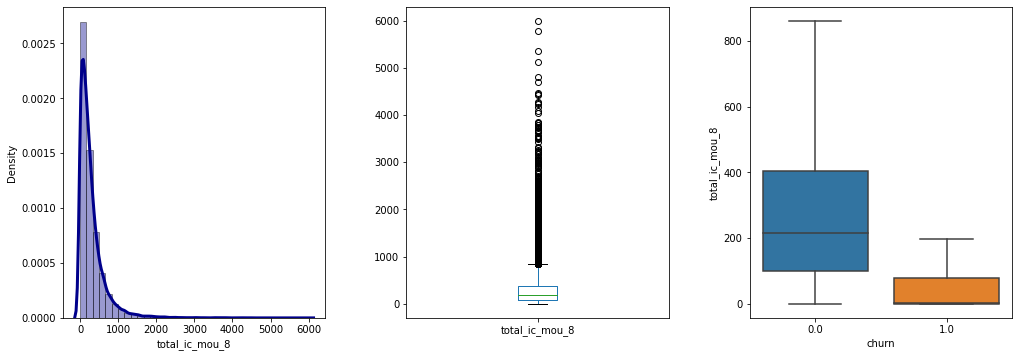

In [120]:
plot_numerical(df3,'total_ic_mou_8','churn')

'total_ic_mou_8' has outliers above the upper whisker. Accounts with lower 'total_ic_mou_8' are more likely churn.

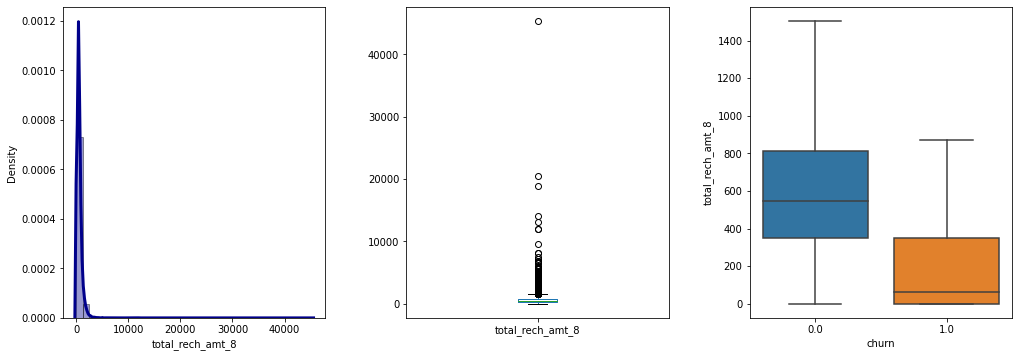

In [121]:
plot_numerical(df3,'total_rech_amt_8','churn')

'total_rech_amt_8' has outliers above the upper whisker. Accounts with lower 'total_rech_amt_8' are more likely churn.

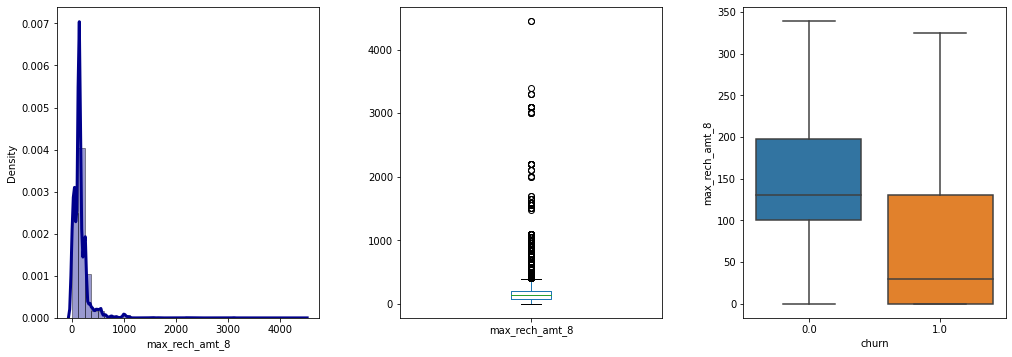

In [122]:
plot_numerical(df3,'max_rech_amt_8','churn')

'max_rech_amt_8' has outliers above the upper whisker. Accounts with lower 'max_rech_amt_8' are more likely churn.

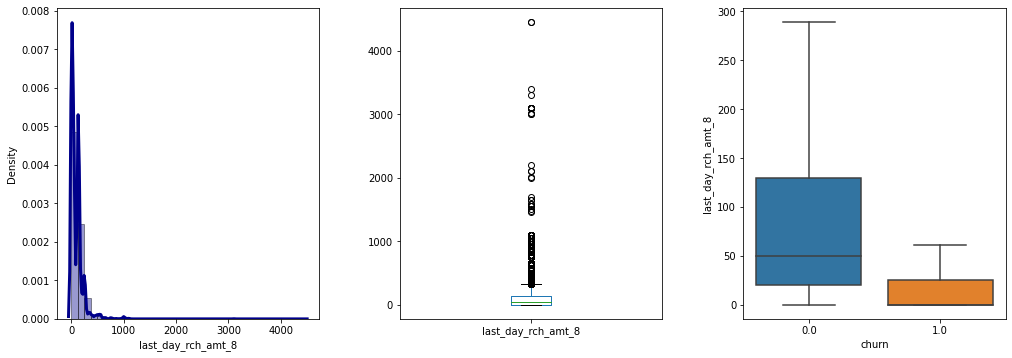

In [123]:
plot_numerical(df3,'last_day_rch_amt_8','churn')

'last_day_rch_amt_8' has outliers above the upper whisker. Accounts with lower 'last_day_rch_amt_8' are more likely churn.

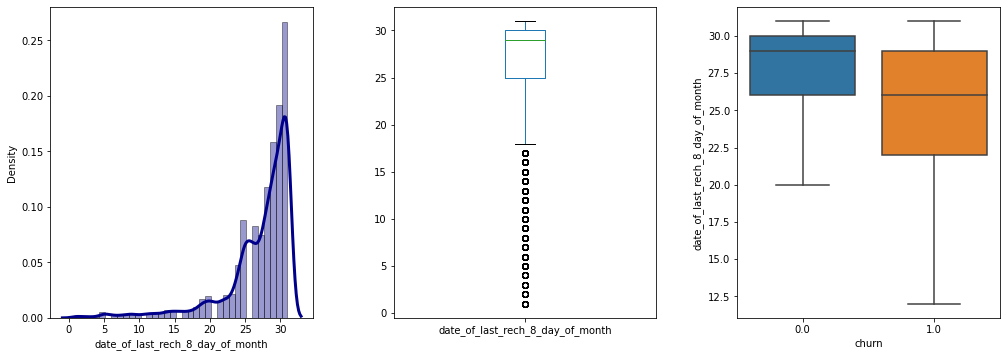

In [124]:
plot_numerical(df3,'date_of_last_rech_8_day_of_month','churn')

'date_of_last_rech_8_day_of_month' has outliers below the lower whisker. Accounts with lower 'date_of_last_rech_8_day_of_month' are more likely churn.

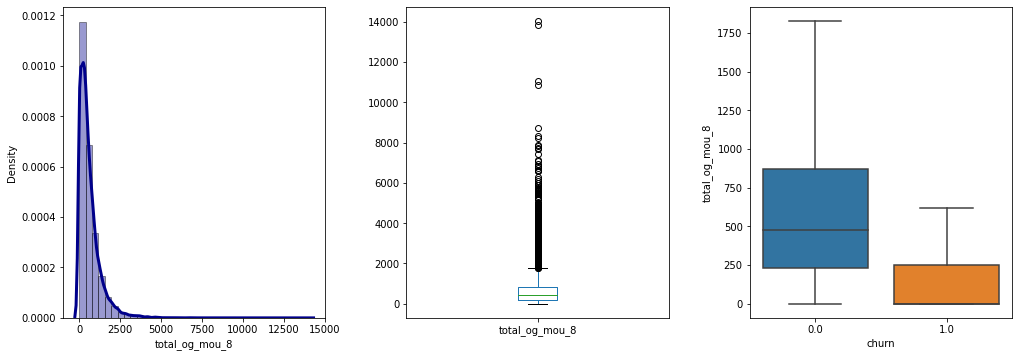

In [125]:
plot_numerical(df3,'total_og_mou_8','churn')

'total_og_mou_8' has outliers above the upper whisker. Accounts with lower 'total_og_mou_8' are more likely churn.

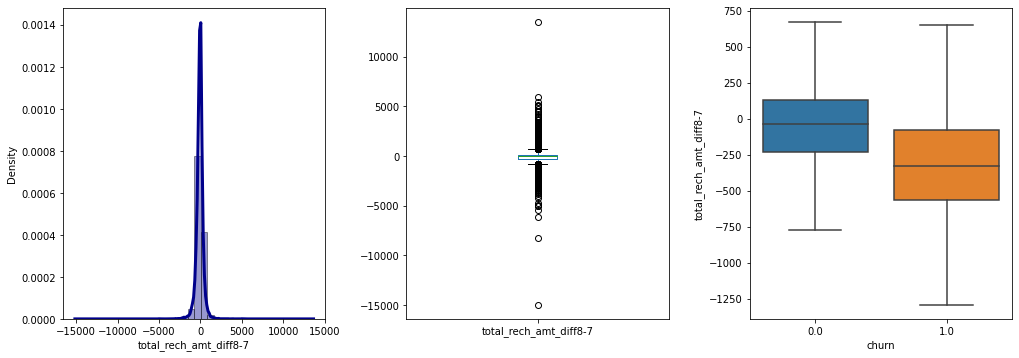

In [126]:
plot_numerical(df3,'total_rech_amt_diff8-7','churn')

'total_rech_amt_diff8-7' has outliers above the upper whisker as well as below the lower whisker. Accounts with lower 'total_rech_amt_diff8-7' are more likely churn.

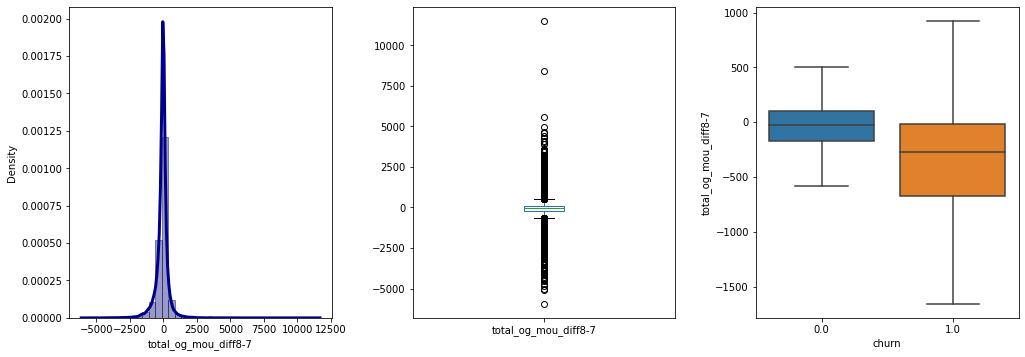

In [127]:
plot_numerical(df3,'total_og_mou_diff8-7','churn')

'total_og_mou_diff8-7' has outliers above the upper whisker as well as below the lower whisker. Accounts with lower 'total_og_mou_diff8-7' are more likely churn.

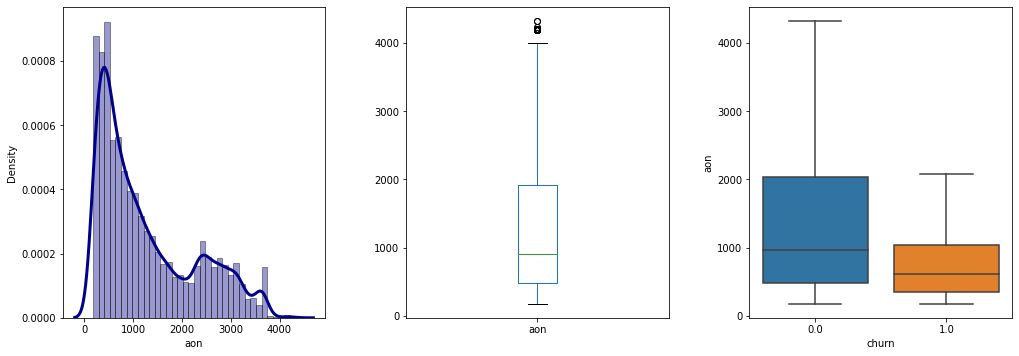

In [128]:
plot_numerical(df3,'aon','churn')

'aon' has outliers above the upper whisker. Accounts with lower 'aon' are more likely churn.

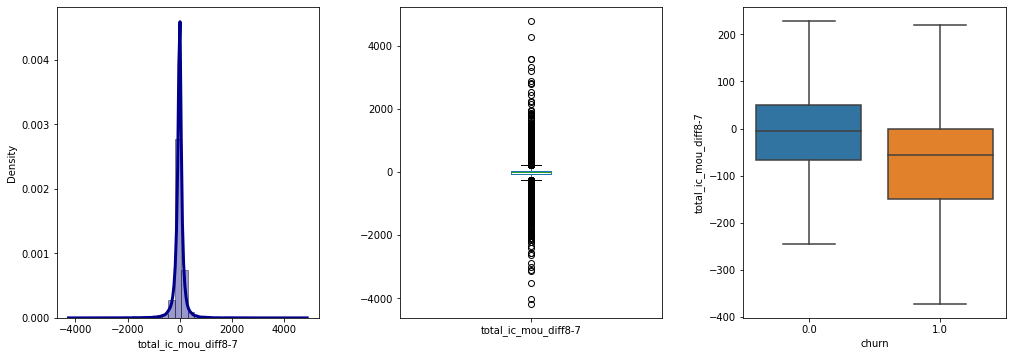

In [129]:
plot_numerical(df3,'total_ic_mou_diff8-7','churn')

'total_ic_mou_diff8-7' has outliers above the upper whisker as well as below the lower whisker. Accounts with lower 'total_ic_mou_diff8-7' are more likely churn.

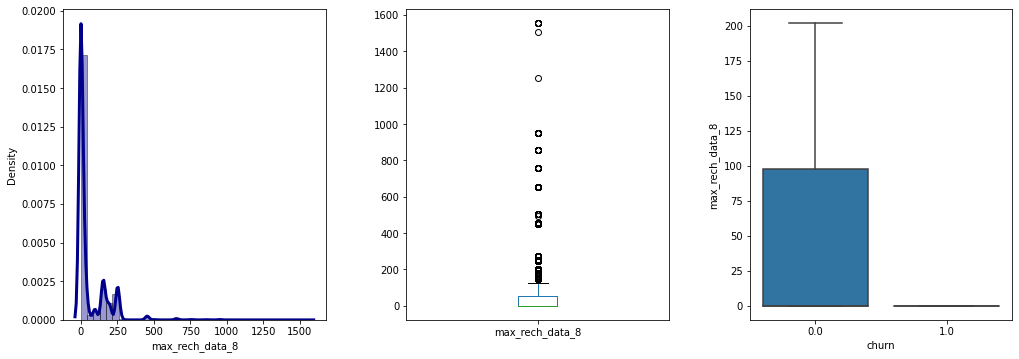

In [130]:
plot_numerical(df3,'max_rech_data_8','churn')

'max_rech_data_8' has outliers above the upper whisker. Accounts with zero 'max_rech_data_8' are more likely churn.

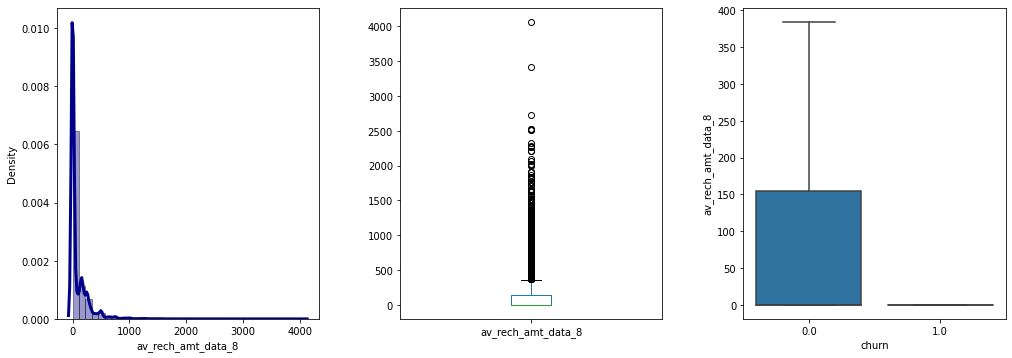

In [131]:
plot_numerical(df3,'av_rech_amt_data_8','churn')

'av_rech_amt_data_8' has outliers above the upper whisker. Accounts with zero 'av_rech_amt_data_8' are more likely churn.

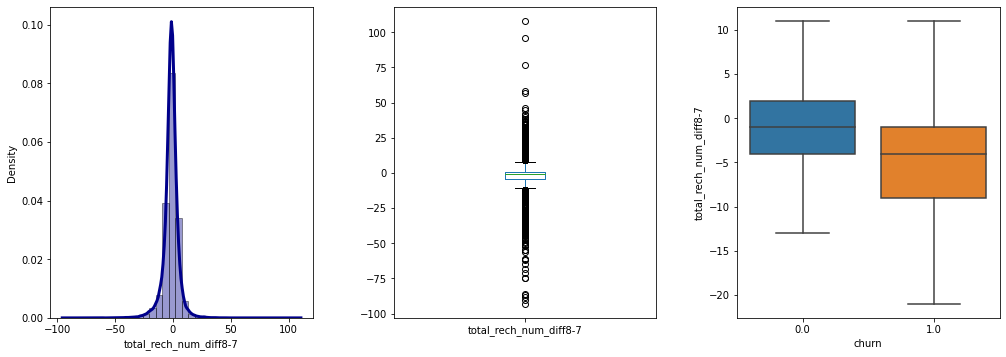

In [132]:
plot_numerical(df3,'total_rech_num_diff8-7','churn')

'total_rech_num_diff8-7' has outliers above the upper whisker as well as below the lower whisker. Accounts with lower 'total_rech_num_diff8-7' are more likely churn.

## Outlier Treatment

In [133]:
# Capping outliers at 1st and 99th percentile

df3 = cap_outliers(df3)

## Handling Imbalanced Data

In [134]:
# Checking for data imbalance

df3.churn.value_counts(normalize = True)

0.0    0.906468
1.0    0.093532
Name: churn, dtype: float64

Text(0.5, 1.0, 'Class Distributions \n (0: No Churn || 1: Churn)')

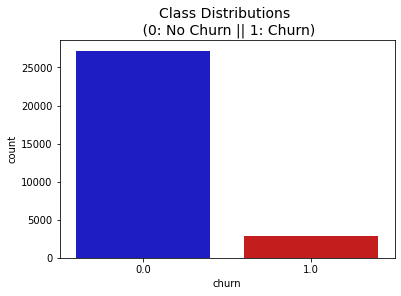

In [135]:
sns.countplot('churn', data=df3, palette=["#0101DF", "#DF0101"])
plt.title('Class Distributions \n (0: No Churn || 1: Churn)', fontsize=14)

We can see that there is an imbalance in the target variable ("churn")

In [136]:
# Create Train and Test Sets

y = df3.churn
X = df3.drop('churn', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=56)

print("Proportion of churners in the train set: ", round(y_train.mean(),2))
print("Proportion of churners in the test set: ", round(y_test.mean(),2))

Proportion of churners in the train set:  0.09
Proportion of churners in the test set:  0.09


## The Imbalance Problem

Randomforest modeling without imbalance correction

In [137]:
# Random Forest - Base

rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

print_scores(rf, X_test, y_test)


 Test Set ROC AUC:  0.94

 Clasification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      8162
         1.0       0.73      0.46      0.57       842

    accuracy                           0.93      9004
   macro avg       0.84      0.72      0.77      9004
weighted avg       0.93      0.93      0.93      9004


 Confussion Matrix:
 [[8016  146]
 [ 452  390]]


## Let's see different resampling techniques and use the one with the highest Recall/Sensitivity

Random Undersampling

In [138]:
# Random Undersampling

under_sample = RandomUnderSampler(random_state = 5)
X_resampled_us, y_resampled_us = under_sample.fit_resample(X_train, y_train)
len(X_resampled_us)

3930

In [139]:
# Random Forest - Random UnderSampling

rf_us = RandomForestClassifier(n_jobs=-1)
rf_us.fit(X_resampled_us, y_resampled_us)

print_scores(rf_us, X_test, y_test)


 Test Set ROC AUC:  0.93

 Clasification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.98      0.89      0.93      8162
         1.0       0.44      0.85      0.58       842

    accuracy                           0.89      9004
   macro avg       0.71      0.87      0.76      9004
weighted avg       0.93      0.89      0.90      9004


 Confussion Matrix:
 [[7264  898]
 [ 130  712]]


Tomek Links

In [140]:
# Tomek Links

tomek_sample = TomekLinks(sampling_strategy='majority')
X_resampled_tomek, y_resampled_tomek = tomek_sample.fit_resample(X_train, y_train)
len(X_resampled_tomek)

20625

In [141]:
# Random Forest - Tomek Links

rf_tomek = RandomForestClassifier(n_jobs=-1)
rf_tomek.fit(X_resampled_tomek, y_resampled_tomek)

print_scores(rf_tomek, X_test, y_test)


 Test Set ROC AUC:  0.93

 Clasification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      8162
         1.0       0.70      0.47      0.56       842

    accuracy                           0.93      9004
   macro avg       0.82      0.73      0.76      9004
weighted avg       0.92      0.93      0.93      9004


 Confussion Matrix:
 [[7993  169]
 [ 445  397]]


Random Oversampling

In [142]:
# Random OverSampling

over_sample = RandomOverSampler(sampling_strategy = 1)
X_resampled_os, y_resampled_os = over_sample.fit_resample(X_train, y_train)
len(X_resampled_os)

38084

In [143]:
# Random Forest - Random Over-Sampling

rf_os = RandomForestClassifier(n_jobs=-1)
rf_os.fit(X_resampled_os, y_resampled_os)

print_scores(rf_os, X_test, y_test)


 Test Set ROC AUC:  0.94

 Clasification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      8162
         1.0       0.69      0.52      0.59       842

    accuracy                           0.93      9004
   macro avg       0.82      0.75      0.78      9004
weighted avg       0.93      0.93      0.93      9004


 Confussion Matrix:
 [[7965  197]
 [ 407  435]]


SMOTE

In [144]:
# SMOTE

smt = SMOTE(random_state=45, k_neighbors=5)
X_resampled_smt, y_resampled_smt = smt.fit_resample(X_train, y_train)
len(X_resampled_smt)

38084

In [145]:
# Random Forest - SMOTE

rf_smt = RandomForestClassifier(n_jobs=-1)
rf_smt.fit(X_resampled_smt, y_resampled_smt)

print_scores(rf_smt, X_test, y_test)


 Test Set ROC AUC:  0.93

 Clasification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      8162
         1.0       0.60      0.65      0.62       842

    accuracy                           0.93      9004
   macro avg       0.78      0.80      0.79      9004
weighted avg       0.93      0.93      0.93      9004


 Confussion Matrix:
 [[7802  360]
 [ 298  544]]


ADASYN

In [146]:
# ADASYN

ada = ADASYN(random_state=45, n_neighbors=5)
X_resampled_ada, y_resampled_ada = ada.fit_resample(X_train, y_train)
len(X_resampled_ada)

37889

In [147]:
# Random Forest - ADASYN

rf_ada = RandomForestClassifier(n_jobs=-1)
rf_ada.fit(X_resampled_ada, y_resampled_ada)

print_scores(rf_ada, X_test, y_test)


 Test Set ROC AUC:  0.93

 Clasification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      8162
         1.0       0.60      0.64      0.62       842

    accuracy                           0.93      9004
   macro avg       0.78      0.80      0.79      9004
weighted avg       0.93      0.93      0.93      9004


 Confussion Matrix:
 [[7802  360]
 [ 303  539]]


SMOTE + TOMEK

In [148]:
# SMOTE+TOMEK

smt_tmk = SMOTETomek(random_state=45)
X_resampled_smt_tmk, y_resampled_smt_tmk = smt_tmk.fit_resample(X_train, y_train)
len(X_resampled_smt_tmk)

38064

In [149]:
# Random Forest - SMOTE+TOMEK

rf_smt_tmk = RandomForestClassifier(n_jobs=-1)
rf_smt_tmk.fit(X_resampled_smt_tmk, y_resampled_smt_tmk)

print_scores(rf_smt_tmk, X_test, y_test)


 Test Set ROC AUC:  0.94

 Clasification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      8162
         1.0       0.61      0.64      0.62       842

    accuracy                           0.93      9004
   macro avg       0.79      0.80      0.79      9004
weighted avg       0.93      0.93      0.93      9004


 Confussion Matrix:
 [[7818  344]
 [ 307  535]]


##The Recall/Sensitivity score for "Random Undersampling" is the highest amongst all the resampling techniques. Hence, we will use the data generated by "Random Undersampling".

In [150]:
y_resampled = y_resampled_us

# Converting "X_resampled_us" to a dataframe with it's respective column names
X_resampled = pd.DataFrame(X_resampled_us, columns=X_train.columns)
X_resampled.head()

,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,night_pck_user_6_N,night_pck_user_6_Y,night_pck_user_7_N,night_pck_user_7_Y,night_pck_user_8_N,night_pck_user_8_Y,date_of_last_rech_6_day_of_week,date_of_last_rech_6_day_of_month,date_of_last_rech_7_day_of_week,date_of_last_rech_7_day_of_month,date_of_last_rech_8_day_of_week,date_of_last_rech_8_day_of_month,av_rech_amt_data_diff7-6,av_rech_amt_data_diff8-7,count_rech_3g_diff7-6,count_rech_3g_diff8-7,ic_others_diff7-6,ic_others_diff8-7,isd_ic_mou_diff7-6,isd_ic_mou_diff8-7,isd_og_mou_diff7-6,isd_og_mou_diff8-7,last_day_rch_amt_diff7-6,last_day_rch_amt_diff8-7,max_rech_amt_diff7-6,max_rech_amt_diff8-7,max_rech_data_diff7-6,max_rech_data_diff8-7,monthly_2g_diff7-6,monthly_2g_diff8-7,monthly_3g_diff7-6,monthly_3g_diff8-7,og_others_diff7-6,og_others_diff8-7,roam_ic_mou_diff7-6,roam_ic_mou_diff8-7,roam_og_mou_diff7-6,roam_og_mou_diff8-7,spl_ic_mou_diff7-6,spl_ic_mou_diff8-7,spl_og_mou_diff7-6,spl_og_mou_diff8-7,total_ic_mou_diff7-6,total_ic_mou_diff8-7,total_og_mou_diff7-6,total_og_mou_diff8-7,total_rech_amt_diff7-6,total_rech_amt_diff8-7,total_rech_data_diff7-6,total_rech_data_diff8-7,total_rech_num_diff7-6,total_rech_num_diff8-7,vol_2g_mb_diff7-6,vol_2g_mb_diff8-7,vol_3g_mb_diff7-6,vol_3g_mb_diff8-7
0,0.0,7.65,10.69,0.0,7.63,4.580,0.00,0.000,0.00,0.00,0.00,6.88,0.00,0.0,0.0,383.01,378.64,391.39,307.84,392.44,391.63,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,9.0,8.0,13.0,430.0,330.0,597.0,110.0,110.0,144.0,110.0,23.0,23.0,0.0,0.0,1.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,191.13,0.0,0.0,283.27,0.0,0.0,0.0,0.0,0.0,0.0,1671.0,360.14,57.59,43.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0,30.0,4.0,29.0,0.0,8.0,0.0,0.0,0.00,0.00,0.00,0.0,0.000,0.00,-87.0,0.0,0.0,34.0,0.0,8.0,0.0,0.0,0.0,0.0,0.00,0.0,7.65,3.04,7.63,-3.050,0.0,0.0,0.00,6.88,84.60,-0.81,-4.370,12.75,-100.0,267.0,0.0,1.0,-1.0,5.0,0.0,191.13,0.0,283.27
1,0.0,0.00,0.00,0.0,0.00,0.000,41.25,40.425,31.24,0.00,0.00,0.00,0.00,0.0,0.0,100.03,89.59,133.34,273.84,320.88,267.58,0.0,0.0,0.0,61.19,62.41,37.31,1.20,0.0,0.00,21.0,19.0,23.0,580.0,645.0,725.0,50.0,110.0,130.0,10.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,495.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,28.0,2.0,30.0,4.0,29.0,0.0,0.0,0.0,0.0,-1.20,0.00,1.22,-25.1,14.813,-0.52,40.0,0.0,60.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.000,0.0,0.0,0.00,0.00,47.04,-53.30,-10.440,43.75,65.0,80.0,0.0,0.0,-2.0,4.0,0.0,0.00,0.0,0.00
2,0.0,0.00,77.69,0.0,0.00,432.743,0.00,0.000,0.00,1.26,15.31,1.91,4.11,0.0,0.0,569.43,1298.86,133.58,73.26,192.99,74.24,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,7.0,11.0,10.0,440.0,896.0,746.0,110.0,110.0,144.0,110.0,100.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1008.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,24.0,1.0,29.0,1.0,26.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.000,0.00,-10.0,30.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.11,0.0,0.00,77.69,0.00,256.687,0.0,0.0

## Logistic Regression

In [151]:
# Scaling 
scaler = StandardScaler() 
X_resampled_std = pd.DataFrame(scaler.fit_transform(X_resampled), columns=X_resampled.columns)

lm = LogisticRegression()
lm.fit(X_resampled_std, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [152]:
# Train Set scores

print_scores(lm, X_train, y_train,mode='Train')


 Train Set ROC AUC:  0.8

 Clasification Report on Train Set:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.94     19042
         1.0       0.38      0.35      0.37      1965

    accuracy                           0.89     21007
   macro avg       0.66      0.65      0.65     21007
weighted avg       0.88      0.89      0.88     21007


 Confussion Matrix:
 [[17935  1107]
 [ 1276   689]]


In [153]:
# Test Set scores

print_scores(lm, X_test, y_test,mode='Test')


 Test Set ROC AUC:  0.78

 Clasification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.94      8162
         1.0       0.38      0.35      0.37       842

    accuracy                           0.89      9004
   macro avg       0.66      0.65      0.65      9004
weighted avg       0.88      0.89      0.88      9004


 Confussion Matrix:
 [[7689  473]
 [ 548  294]]


The logistic regression model has a poor performance due to it's lower recall/sensitivity

## Hyper-parameter tuning using Cross Validation on Resampled Train Set

## Decision Tree

In [154]:
# GridSearchCV

hyper_params_cv_dt = {'max_depth': [5, 25, 100],
                'max_features': [10, 25, 50],
                'min_samples_leaf': [20, 50, 100]
               }

model_cv_dt = GridSearchCV(estimator= DecisionTreeClassifier(), 
             param_grid=hyper_params_cv_dt,
             verbose=1,
             cv=5,
             scoring = "recall",
             n_jobs=-1,
             return_train_score=True)

model_cv_dt.fit(X_resampled, y_resampled)

print(model_cv_dt.best_estimator_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    4.2s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=100, max_features=50, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    4.6s finished


In [155]:
# Train Set Scores

print_scores(model_cv_dt, X_train, y_train,mode='Train')


 Train Set ROC AUC:  0.93

 Clasification Report on Train Set:
               precision    recall  f1-score   support

         0.0       0.98      0.83      0.90     19042
         1.0       0.35      0.87      0.50      1965

    accuracy                           0.84     21007
   macro avg       0.67      0.85      0.70     21007
weighted avg       0.93      0.84      0.86     21007


 Confussion Matrix:
 [[15865  3177]
 [  250  1715]]


In [156]:
print('CV Recall Score: ', round(model_cv_dt.best_score_,2))

# Test Set Scores

print_scores(model_cv_dt, X_test, y_test,mode='Test')

CV Recall Score:  0.84

 Test Set ROC AUC:  0.89

 Clasification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      8162
         1.0       0.33      0.81      0.47       842

    accuracy                           0.83      9004
   macro avg       0.65      0.82      0.68      9004
weighted avg       0.92      0.83      0.86      9004


 Confussion Matrix:
 [[6779 1383]
 [ 162  680]]


The Decision Tree performs moderately well as the recall/sensitivity is high.

## Random Forest with Grid Search

In [157]:
# GridSearchCV

hyper_params_cv_rf = {'max_depth': [5, 25, 100],
                'max_features': [10, 25, 50],
                'min_samples_leaf': [20, 50, 100],
                'n_estimators': [50, 80, 100]
               }

model_cv_rf = GridSearchCV(estimator=RandomForestClassifier(), 
             param_grid=hyper_params_cv_rf,
             verbose=1,
             cv=5,
             scoring = "recall",
             n_jobs=-1,
             return_train_score=True)

model_cv_rf.fit(X_resampled, y_resampled)

print(model_cv_rf.best_estimator_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  5.1min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features=50,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


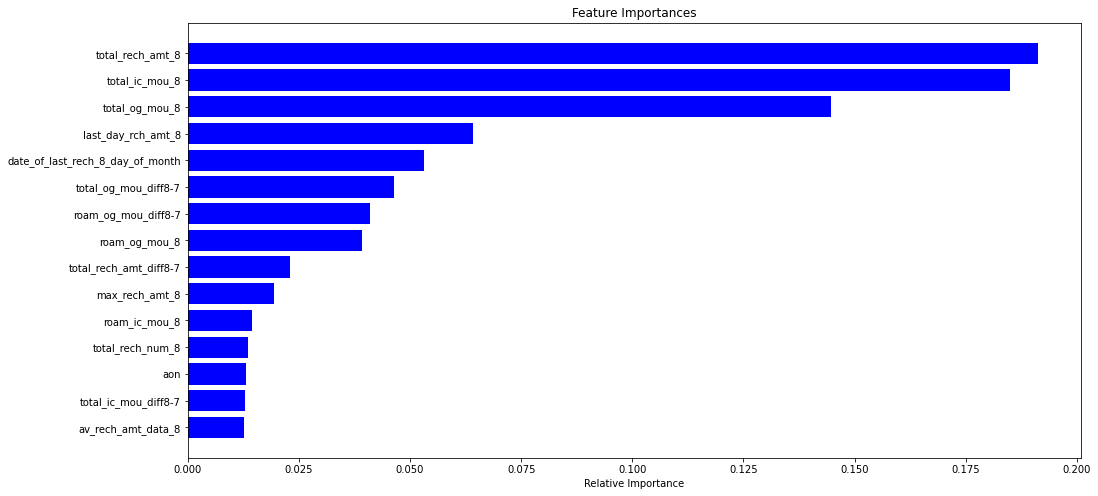

In [158]:
# Feature Importances

features = X_resampled.columns
importances = model_cv_rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [159]:
# Train Set Scores

print_scores(model_cv_rf, X_train, y_train,mode='Train')


 Train Set ROC AUC:  0.95

 Clasification Report on Train Set:
               precision    recall  f1-score   support

         0.0       0.99      0.88      0.93     19042
         1.0       0.43      0.90      0.58      1965

    accuracy                           0.88     21007
   macro avg       0.71      0.89      0.76     21007
weighted avg       0.94      0.88      0.90     21007


 Confussion Matrix:
 [[16703  2339]
 [  202  1763]]


In [160]:
print('CV Recall Score: ', round(model_cv_rf.best_score_,2))

# Test Set Scores

print_scores(model_cv_rf, X_test, y_test,mode='Test')

CV Recall Score:  0.86

 Test Set ROC AUC:  0.94

 Clasification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      8162
         1.0       0.42      0.86      0.57       842

    accuracy                           0.88      9004
   macro avg       0.70      0.87      0.75      9004
weighted avg       0.93      0.88      0.89      9004


 Confussion Matrix:
 [[7177  985]
 [ 122  720]]


Random Forest model performs very well as the recall/sensitivity is high.

## Gradient Boosting

In [161]:
# GridSearchCV


hyper_params_cv_gbc = {'max_depth': [5, 25, 50, 100],
                'max_features': [10, 25, 50],
                'min_samples_leaf': [20, 50, 100],
                'n_estimators': [50, 80, 100]
               }

model_cv_gbc = GridSearchCV(estimator= GradientBoostingClassifier(), 
             param_grid=hyper_params_cv_gbc,
             verbose=1,
             cv=5,
             scoring = "recall",
             n_jobs=-1,
             return_train_score=True)

model_cv_gbc.fit(X_resampled, y_resampled)

print(model_cv_gbc.best_estimator_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 13.7min finished


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=50,
                           max_features=50, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=80,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


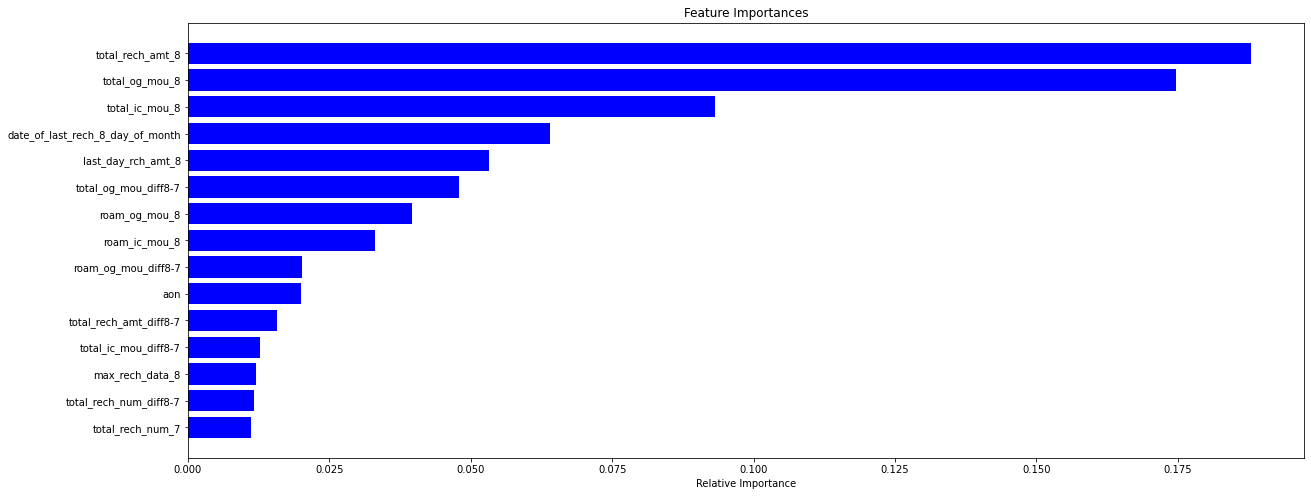

In [162]:
# Feature Importances

features = X_resampled.columns
importances = model_cv_gbc.best_estimator_.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(20,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [163]:
# Train Set Scores

print_scores(model_cv_gbc, X_train, y_train,mode='Train')


 Train Set ROC AUC:  0.98

 Clasification Report on Train Set:
               precision    recall  f1-score   support

         0.0       1.00      0.89      0.94     19042
         1.0       0.49      1.00      0.65      1965

    accuracy                           0.90     21007
   macro avg       0.74      0.95      0.80     21007
weighted avg       0.95      0.90      0.92     21007


 Confussion Matrix:
 [[16962  2080]
 [    1  1964]]


In [164]:
print('CV Recall Score: ', round(model_cv_gbc.best_score_,2))

# Test Set Scores

print_scores(model_cv_gbc, X_test, y_test,mode='Test')

CV Recall Score:  0.88

 Test Set ROC AUC:  0.94

 Clasification Report on Test Set:
               precision    recall  f1-score   support

         0.0       0.98      0.89      0.93      8162
         1.0       0.44      0.86      0.58       842

    accuracy                           0.88      9004
   macro avg       0.71      0.87      0.76      9004
weighted avg       0.93      0.88      0.90      9004


 Confussion Matrix:
 [[7236  926]
 [ 118  724]]


**Gradient Boosting model also performs very well as the recall/sensitivity is high. This is the best model as it's recall and precision are the highest amongst all models.**

## Recommendations

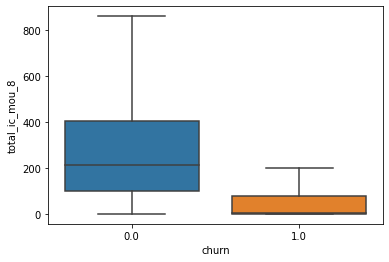

In [165]:
sns.boxplot(x="churn", y="total_ic_mou_8", data=df3,showfliers = False)

When a customer has low "total incoming minutes of usage" (close to 0) in the present month (8), then that customer is more likely to churn in the next month (9). Taking some form of preventive meaures can help not lose the customer.

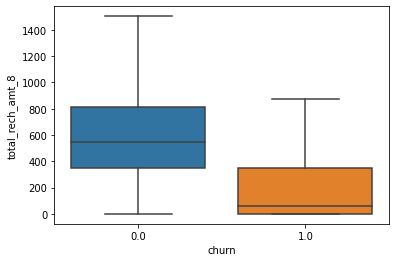

In [166]:
sns.boxplot(x="churn", y="total_rech_amt_8", data=df3,showfliers = False)

When a customer has low "total_rech_amt_8" (less than 100) in the present month (8), then that customer is more likely to churn in the next month. Taking some form of preventive meaures can help not lose the customer.


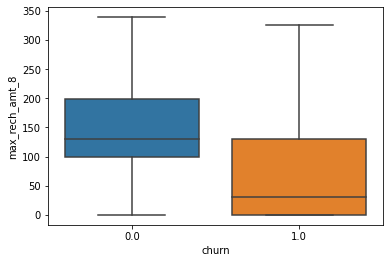

In [167]:
sns.boxplot(x="churn", y="max_rech_amt_8", data=df3,showfliers = False)

When a customer has low "max_rech_amt_8" (less than 50) in the present month (8), then that customer is more likely to churn in the next month. Taking some form of preventive meaures can help not lose the customer.


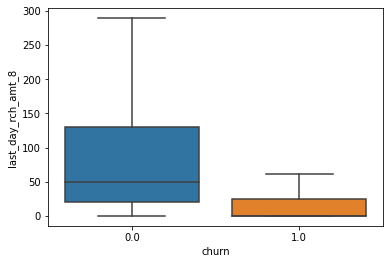

In [168]:
sns.boxplot(x="churn", y="last_day_rch_amt_8", data=df3,showfliers = False)

When a customer has low "last_day_rch_amt" (close to 0) in the present month (8), then that customer is more likely to churn in the next month. Taking some form of preventive meaures can help not lose the customer.

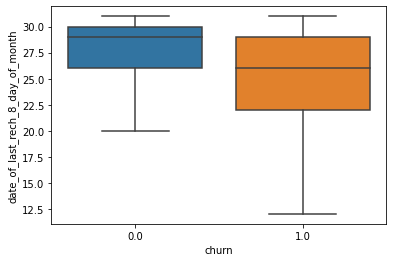

In [169]:
sns.boxplot(x="churn", y="date_of_last_rech_8_day_of_month", data=df3,showfliers = False)

When a customer has earlier "date_of_last_rech_day_of_month" in the present month (8), then that customer is more likely to churn in the next month. Taking some form of preventive meaures can help not lose the customer.

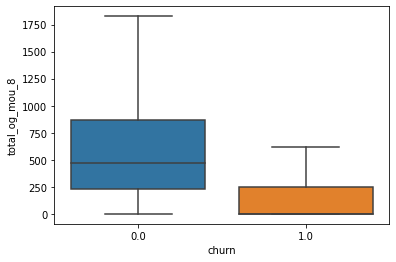

In [170]:
sns.boxplot(x="churn", y="total_og_mou_8", data=df3,showfliers = False)

When a customer has low "total out-going minutes of usage" (close to 0) in the present month (8), then that customer is more likely to churn in the next month. Taking some form of preventive meaures can help not lose the customer.

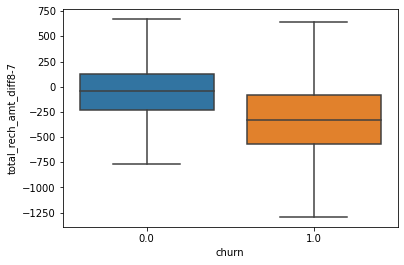

In [171]:
sns.boxplot(x="churn", y="total_rech_amt_diff8-7", data=df3,showfliers = False)

When a customer has lower "total_rech_amt" in current month (8) than "total_rech_amt" in previous month (7), then that customer is more likely to churn in the next month. Taking some form of preventive meaures can help not lose the customer.

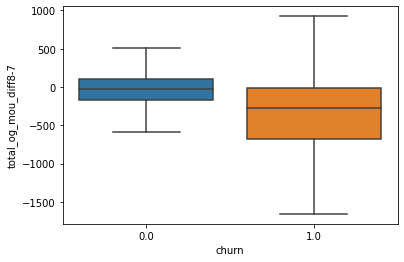

In [172]:
sns.boxplot(x="churn", y="total_og_mou_diff8-7", data=df3,showfliers = False)

When a customer has lower "total out-going minutes of usage" in current month (8) than "total out-going minutes of usage" in previous month(7), then that customer is more likely to churn in the next month. Taking some form of preventive meaures can help not lose the customer.

# Fin!